In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from plotting import validation_plot, validation_titration_plot
from data_loading import (load_n2h_ppi_validation_data,
                          load_full_y2h_data_including_controls)

In [2]:
df = load_n2h_ppi_validation_data()

In [3]:
# TODO: remove this once everything finalized 
# (they should already be removed in the table)

# sequence confirmation was done after the expeirment design
# so need to remove sequence failures
y2h = load_full_y2h_data_including_controls()
y2h = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :]
y2h_positives = y2h.loc[y2h['Y2H_result'] == True, ['ad_orf_id', 'db_orf_id']].values
y2h_positives = set(map(tuple, y2h_positives))
y2h_negatives = y2h.loc[y2h['Y2H_result'] == False, ['ad_orf_id', 'db_orf_id']].values
y2h_negatives = set(map(tuple, y2h_negatives))

# check positives / negatives are in Y2H dataset
def in_y2h_positves(row):
    pair = (row['test_orf_idb'],
            row['test_orf_ida'])
    return pair in y2h_positives


def in_y2h_negatives(row):
    pair = (row['test_orf_idb'],
            row['test_orf_ida'])
    return pair in y2h_negatives


df = df.loc[~((df['source'] == 'isoform positives') & 
            ~df.apply(in_y2h_positves, axis=1)), :]
df = df.loc[~((df['source'] == 'isoform negatives') & 
            ~df.apply(in_y2h_negatives, axis=1)), :]

In [4]:
COLOR_LIT = (60 / 255, 134 / 255, 184 / 255)
COLOR_HURI = (155 / 255, 97 / 255, 153 / 255)
colors = {    
    'vignettes': 'yellow', 
    'isoform positives': COLOR_HURI,
     'RRS - TF space specific': 'tab:red',
      'Lit-BM - TF space specific': COLOR_LIT,
       'isoform negatives': 'grey',
        'RRS - from HuRI': 'tab:red',
        'Lit-BM-13': COLOR_LIT,
        'PRS - hPRS-v2': COLOR_LIT,
        'RRS - hRRS-v2': 'tab:red'}

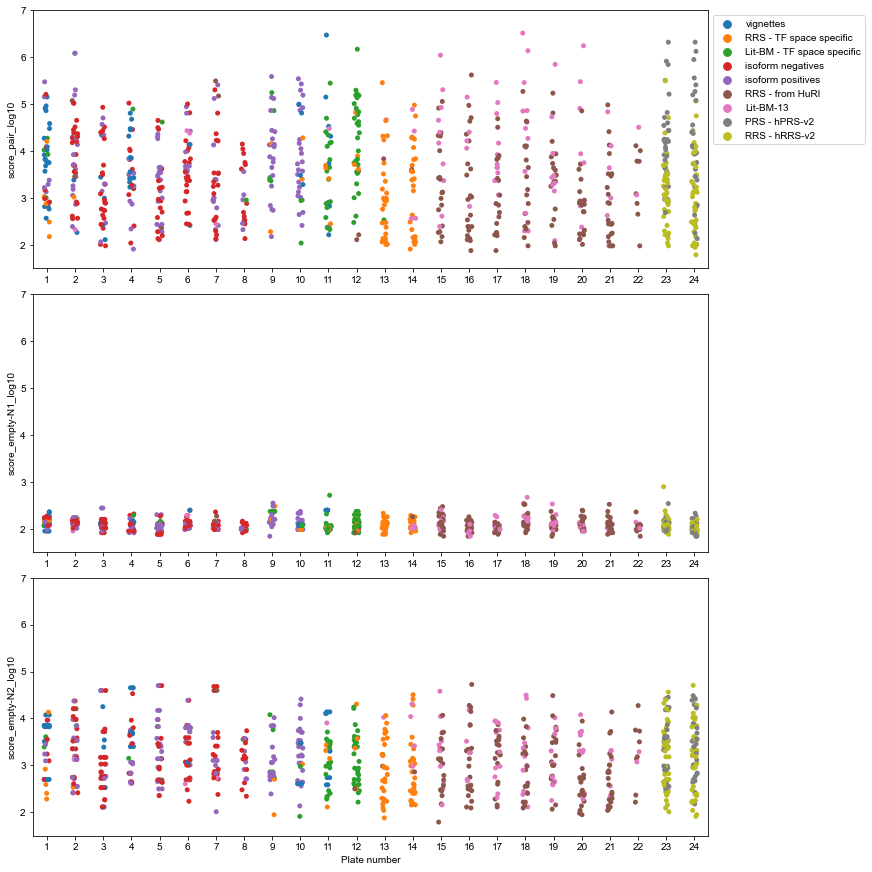

In [5]:
# NOTE: the plate numbers here for the controls for the PRS/RRS are incorrect
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(h=12, w=12)
sns.stripplot(data=df, y='score_pair_log10', x='test_pla', hue='source', ax=axs[0])
sns.stripplot(data=df, y='score_empty-N1_log10', x='test_pla', hue='source', ax=axs[1])
sns.stripplot(data=df, y='score_empty-N2_log10', x='test_pla', hue='source', ax=axs[2])
for ax in axs:
    ax.set_ylim(1.5, 7)
axs[0].legend(bbox_to_anchor=(1., 1.))
axs[1].get_legend().remove()
axs[2].get_legend().remove()
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('Plate number')
fig.savefig('../figures/TFv02_scores-by-plate-and-category.pdf',
            bbox_inches='tight')

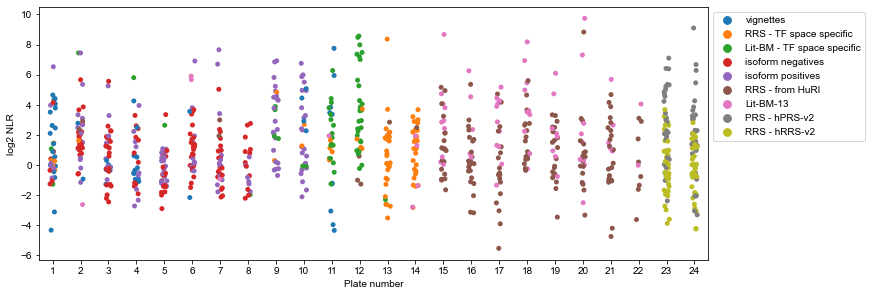

In [6]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(h=4, w=12)
sns.stripplot(data=df, y='log2 NLR', x='test_pla', hue='source', ax=ax)
ax.legend(bbox_to_anchor=(1., 1.))
ax.set_xlabel('Plate number')
fig.savefig('../figures/TFv02_NLR-by-plate-and-category.pdf',
            bbox_inches='tight')

In [7]:
df['source'].value_counts()

RRS - from HuRI               157
isoform negatives             131
isoform positives             131
RRS - hRRS-v2                  78
Lit-BM-13                      75
RRS - TF space specific        71
Lit-BM - TF space specific     62
PRS - hPRS-v2                  60
vignettes                      56
Name: source, dtype: int64

In [8]:
df['source'].unique()

array(['vignettes', 'RRS - TF space specific',
       'Lit-BM - TF space specific', 'isoform negatives',
       'isoform positives', 'RRS - from HuRI', 'Lit-BM-13',
       'PRS - hPRS-v2', 'RRS - hRRS-v2'], dtype=object)

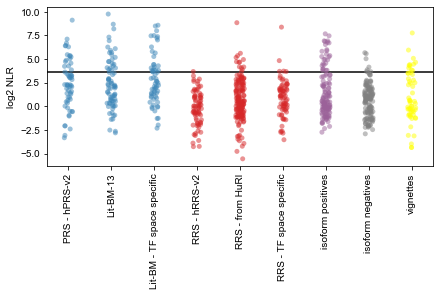

In [9]:
sources = [
           'PRS - hPRS-v2', 
            'Lit-BM-13', 
            'Lit-BM - TF space specific',
            'RRS - hRRS-v2',
            'RRS - from HuRI', 
            'RRS - TF space specific',
            'isoform positives', 
            'isoform negatives',
            'vignettes',
           ]
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df, 
              x='source',
              y='log2 NLR', 
              order=sources,
              ax=ax,
              alpha=0.5,
              palette=colors)
ax.tick_params(axis="x", rotation=90)
ax.axhline(y=df.loc[df['source'] == 'RRS - hRRS-v2', 'log2 NLR'].max(), color='black')
ax.set_xlabel('')
fig.savefig('../figures/TFv02_categories_points.pdf',
            bbox_inches='tight')

<ipython-input-10-31959d1860fd>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])


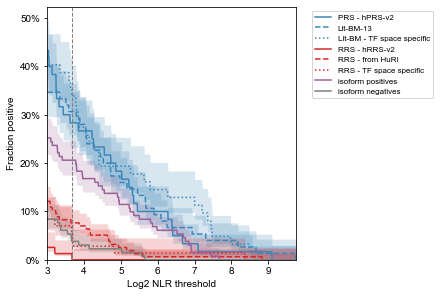

In [10]:
sources = [
           'PRS - hPRS-v2', 
            'Lit-BM-13', 
            'Lit-BM - TF space specific',
            'RRS - hRRS-v2',
            'RRS - from HuRI', 
            'RRS - TF space specific',
            'isoform positives', 
            'isoform negatives',
           ]
line_styles = ['-', '--', ':', '-', '--', ':', '-', '-']
fig, ax = plt.subplots(1, 1)
validation_titration_plot(data=df, 
                          selections=[df['source'] == x for x in sources],
                          labels=sources,
                          colors=[colors[x] for x in sources],
                          line_styles=line_styles,
                          score_column='log2 NLR',
                          threshold=df.loc[df['source'] == 'RRS - hRRS-v2', 'log2 NLR'].max(),
                          xmin=3,
                          ax=ax)
ax.set_xlabel('Log2 NLR threshold')
ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])
fig.savefig('../figures/TFv02_titration.pdf',
            bbox_inches='tight')

In [11]:
df['source'].unique()

array(['vignettes', 'RRS - TF space specific',
       'Lit-BM - TF space specific', 'isoform negatives',
       'isoform positives', 'RRS - from HuRI', 'Lit-BM-13',
       'PRS - hPRS-v2', 'RRS - hRRS-v2'], dtype=object)

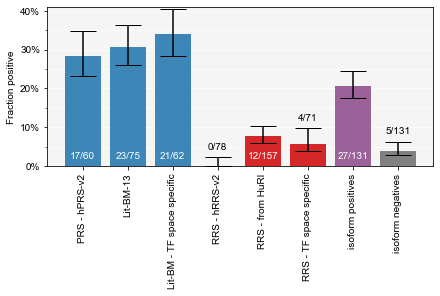

In [12]:
# bar chart
df['result'] = df['NLR'] > df.loc[df['source'] == 'RRS - hRRS-v2', 'NLR'].max()

fig, ax = plt.subplots(1, 1)
validation_plot(data=df,
                selections=[df['source'] == x for x in sources],
                labels=[str(x) for x in sources],
                colors=[colors[x] for x in sources],
                result_column='result',
                errorbar_capsize=0.1,
                y_max=0.41,
                xlabel_rotation=90)
ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])
fig.savefig('../figures/TFv02_bar.pdf',
            bbox_inches='tight')

In [13]:
stats.fisher_exact([[27, 133-27], [5, 133-5]])

SignificanceResult(statistic=6.520754716981132, pvalue=4.1504007212827796e-05)

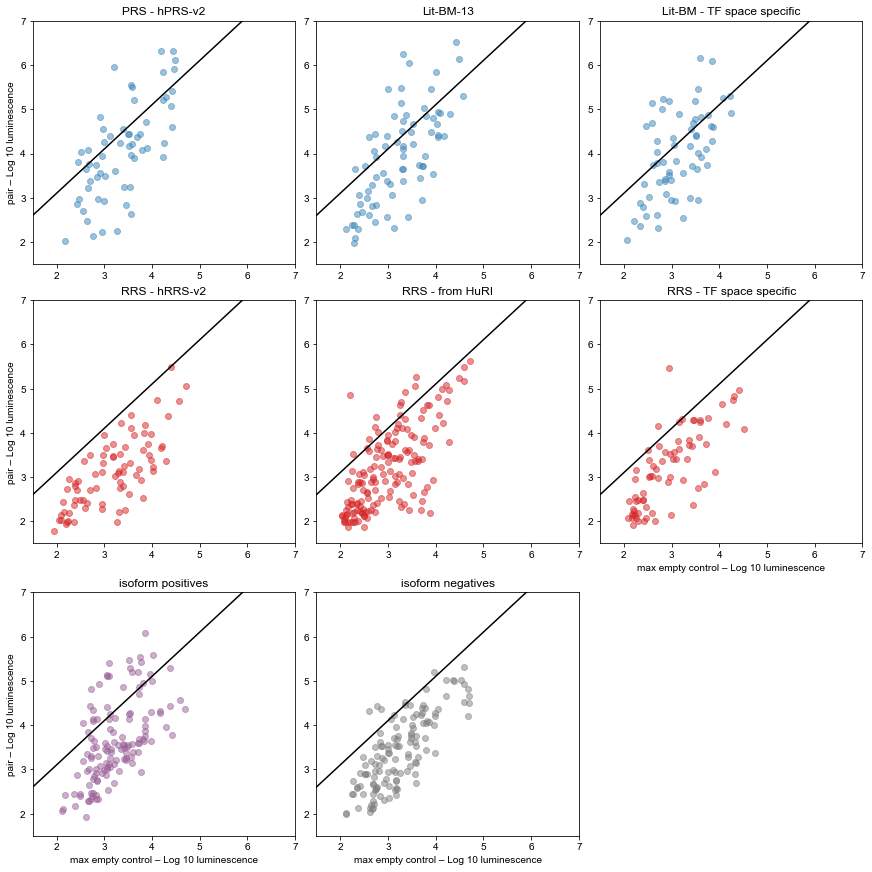

In [14]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(12, 12)
s_min = 1.5
s_max = 7
cutoff = df.loc[df['source'] == 'RRS - hRRS-v2', 'log2 NLR'].max()
for source, ax in zip(sources, axs.flatten()):
    ax.scatter(df.loc[df['source'] == source, ['score_empty-N1_log10', 'score_empty-N2_log10']].max(axis=1).values,
               df.loc[df['source'] == source, 'score_pair_log10'].values,
               color=colors[source],
               alpha=0.5)
    ax.set_title(source)
    ax.set_xlim(s_min, s_max)
    ax.set_ylim(s_min, s_max)
    ax.plot([s_min, s_max],
            [s_min + np.log10(2 ** cutoff), s_max + np.log10(2 ** cutoff)],
             color='black')
for ax in axs[-1, :]:
    ax.set_xlabel('max empty control – Log 10 luminescence')
for ax in axs[:, 0]:
    ax.set_ylabel('pair – Log 10 luminescence')
axs[-1, -1].axis('off')
axs[-2, -1].set_xlabel('max empty control – Log 10 luminescence')
fig.savefig('../figures/TFv02_control-vs-pair_scatter.pdf',
            bbox_inches='tight')

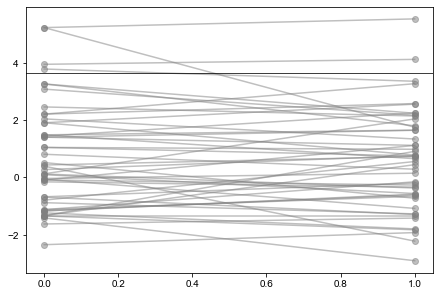

In [19]:
# pair plot
pairs = []
for _i, row_p in df.loc[df['source'] == 'isoform positives', :].iterrows():
    tf_gene = row_p['gene_symbol_tf']
    for _j, row_n in df.loc[(df['source'] == 'isoform negatives') &
                            (df['gene_symbol_tf'] == tf_gene) &
                            (df['test_orf_ida'] == row_p['test_orf_ida']), :].iterrows():
        pairs.append((tf_gene, 
                      row_p['test_orf_idb'],
                      row_n['test_orf_idb'],
                      row_n['test_orf_ida'],
                      row_p['clone_acc'],
                       row_n['clone_acc'],
                       row_n['gene_symbol_partner'],
                      row_p['log2 NLR'],
                      row_n['log2 NLR']))
pairs = pd.DataFrame(pairs, columns=['TF gene', 
                                     'Y2H_positive_orf_id',
                                     'Y2H_negative_orf_id',
                                     'partner_orf_id',
                                     'Y2H_positive_iso_acc',
                                     'Y2H_negative_iso_acc',
                                     'partner gene',
                                     'log2_NLR_Y2H_positive',
                                     'log2_NLR_Y2H_negative'])
fig, ax = plt.subplots(1, 1)
for _i, pair in pairs.iterrows():
    ax.plot([0, 1], pair[['log2_NLR_Y2H_positive', 'log2_NLR_Y2H_negative']].values, '-o', color='grey', alpha=0.5)
ax.axhline(y=cutoff, color='black', linewidth=0.75)

In [20]:
pairs.sort_values('log2_NLR_Y2H_negative', ascending=False).head()

,TF gene,Y2H_positive_orf_id,Y2H_negative_orf_id,partner_orf_id,Y2H_positive_iso_acc,Y2H_negative_iso_acc,partner gene,log2_NLR_Y2H_positive,log2_NLR_Y2H_negative
18,MEOX1,100645,100810,856,MEOX1|1/3|08C05,MEOX1|2/3|08G04,TCEANC,5.249682,5.554589
3,IKZF2,101070,101390,10016,IKZF2|1/4|02B07,IKZF2|2/4|12C01,IKZF3,3.964003,4.136750
40,MEIS2,100717,101369,8787,MEIS2|1/4|08H09,MEIS2|3/4|11H09,IL16,3.798966,3.370145
27,PATZ1,101008,100444,56482,PATZ1|2/4|02D04,PATZ1|1/4|02C02,IQUB,2.219055,3.284749
26,PATZ1,101008,101054,56482,PATZ1|2/4|02D04,PATZ1|3/4|02A04,IQUB,2.219055,2.589552


In [22]:
vignettes = df.loc[df['source'] == 'vignettes', :].copy()

In [23]:
vignettes.sort_values(['gene_symbol_tf', 'gene_symbol_partner', 'clone_acc'])

,test_orf_ida,test_orf_idb,test_pla,test_pos_pair,score_pair,pair,source,test_pos_empty-N1,score_empty-N1,test_pos_empty-N2,score_empty-N2,clone_acc,gene_symbol_tf,gene_symbol_partner,NLR,log2 NLR,score_pair_log10,score_empty-N1_log10,score_empty-N2_log10,result
7,54731,101414,1,B06,10583.0,54731_101414,vignettes,B07,117.0,A02,501.0,ATF2|1/6|12H04,ATF2,ATF2,21.123752,4.400794,4.024609,2.068186,2.699838,True
0,54731,101256,1,A01,8351.0,54731_101256,vignettes,A03,137.0,A02,501.0,ATF2|2/6|09E05,ATF2,ATF2,16.668663,4.059066,3.921738,2.136721,2.699838,True
14,54731,101254,1,C07,5686.0,54731_101254,vignettes,C08,124.0,A02,501.0,ATF2|3/6|09C05,ATF2,ATF2,11.349301,3.504532,3.754807,2.093422,2.699838,False
18,54731,100345,1,C11,659.0,54731_100345,vignettes,C12,89.0,A02,501.0,ATF2|5/6|09A05,ATF2,ATF2,1.315369,0.395468,2.818885,1.949390,2.699838,False
21,54731,100448,1,D06,728.0,54731_100448,vignettes,D07,185.0,A02,501.0,ATF2|6/6|09H03,ATF2,ATF2,1.453094,0.539128,2.862131,2.267172,2.699838,False
8,12504,101414,1,B08,3729.0,12504_101414,vignettes,B07,117.0,A05,6709.0,ATF2|1/6|12H04,ATF2,FOSL2,0.555821,-0.847309,3.571592,2.068186,3.826658,False
1,12504,101256,1,A04,6709.0,12504_101256,vignettes,A03,137.0,A05,6709.0,ATF2|2/6|09E05,ATF2,FOSL2,1.000000,0.000000,3.826658,2.136721,3.826658,False
15,12504,101254,1,C09,4876.0,12504_101254,vignettes,C08,124.0,A05,6709.0,ATF2|3/6|09C05,ATF2,FOSL2,0.726785,-0.460400,3.688064,2.093422,3.826658,False
19,12504,100345,1,D01,5995.0,12504_100345,vignettes,C12,89.0,A05,6709.0,ATF2|5/6|09A05,ATF2,FOSL2,0.893576,-0.162338,3.777789,1.949390,3.826658,False
23,12504,100448,1,D08,12321.0,12504_100448,vignettes,D07,185.0,A05,6709.0,ATF2|6/6|09H03,ATF2,FOSL2,1.836488,0.876950,4.090646,2.267172,3.826658,False
